<a href="https://colab.research.google.com/github/kmsako/BERT/blob/main/TypeB_AntsBees_VGG16_PyTorch_Training_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ants Bees VGG16 による解析

# Fitting

# TypeBによるTrainingクラスの作成

In [1]:
%pwd
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
'''
3. 前処理前後の画像を確認する
'''
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import torch
import torch.utils.data as data
from pathlib import Path


In [3]:
torch.cuda.synchronize()
print(torch.cuda.memory_allocated())

0


In [11]:
data_dir = '/content/gdrive/My Drive/Colab Notebooks/AntsBees_TypeB/data'
root_dir= '/content/gdrive/My Drive/Colab Notebooks/AntsBees_TypeB/data/hymenoptera_data'

In [7]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks/AntsBees_TypeB')
print(os.getcwd())

/content/gdrive/My Drive/Colab Notebooks/AntsBees_TypeB


###Deviceの設定

In [8]:
# 使用可能なデバイス(CPUまたはGPU）を取得する
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#(1) DataSet の作成

### train_list, val_list の作成

In [19]:
import glob
import pprint

def make_datapath_list(phase='train'):
    '''
    データのファイルパスを格納したリストを作成する。

    Parameters:
      phase(str): 'train'または'val'

    Returns:
      path_list(list): 画像データのパスを格納したリスト
    '''
    # 画像ファイルのルートディレクトリ
    # 画像ファイルパスのフォーマットを作成
    # rootpath +
    #   train/ants/*.jpg
    #   train/bees/*.jpg
    #   val/ants/*.jpg
    #   val/bees/*.jpg
    tt= phase +'/**/*.jpg'
    target_path = os.path.join(root_dir,tt)
    # ファイルパスを格納するリスト
    path_list = []  # ここに格納する

    # glob()でファイルパスを取得してリストに追加
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list

# ファイルパスのリストを生成
train_list = make_datapath_list(phase='train')
val_list = make_datapath_list(phase='val')
file_list = {'train': train_list, 'val': val_list}







In [20]:
p=Path(train_list[5])
print(p)
print(p.parts[-2])

p2=Path(val_list[-4])
print(p2.parts[-2])

/content/gdrive/My Drive/Colab Notebooks/AntsBees_TypeB/data/hymenoptera_data/train/ants/1262877379_64fcada201.jpg
ants
bees


#（２）DataSetの作成

In [15]:
from dsets.dsets import MakeDataset
from util.ImageTransform import ImageTransform

In [21]:
'''
6. データローダーの生成
'''
import torch

# ミニバッチのサイズを指定
batch_size = 10
SIZE = 224
# 標準化する際の各RGBの平均値
MEAN = (0.485, 0.456, 0.406) # ImageNetデータセットの平均値を使用
# 標準化する際の各RGBの標準偏差
STD = (0.229, 0.224, 0.225)  # ImageNetデータセットの標準偏差を使用


# 画像のサイズ、平均値、標準偏差の定数値
size, mean, std = SIZE, MEAN, STD

# MakeDatasetで前処理後の訓練データと正解ラベルを取得
train_dataset = MakeDataset(
    file_list=file_list, # 訓練データのファイルパス
    transform=ImageTransform(size, mean, std), # 前処理後のデータ
    phase='train')
# MakeDatasetで前処理後の検証データと正解ラベルを取得
val_dataset = MakeDataset(
    file_list=file_list, # 検証データのファイルパス
    transform=ImageTransform(size, mean, std), # 前処理後のデータ
    phase='val')


In [22]:
print(len(train_list))
print(len(val_list))

242
153


#(2) DataLoader の作成

In [23]:
'''
6. データローダーの生成
'''
from torch.utils.data import DataLoader

# 訓練用のデータローダー:(バッチサイズ, 3, 224, 224)を生成
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 検証用のデータローダー:(バッチサイズ, 3, 224, 224)を生成
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



#(4) モデルの作成

###初期学習と継続学習とを区別する

In [24]:
from models.networks import network_vgg16



In [25]:
'''
7. 学習済みのVGG16モデルをロード
'''
from torchvision import models
import torch.nn as nn

class Model():

  def __init__(self,save_dir,isTrain,use_cuda,continue_train,which_epoch=0):

    self.save_dir = save_dir
    self.isTrain = isTrain
    self.continue_train = continue_train
    self.use_cuda = use_cuda
    self.which_epoch = which_epoch

    if self.isTrain:
      self.model = network_vgg16()
      print('train')
      self.optimizer = torch.optim.SGD(self.model.parameters(), lr=0.001,momentum=0.99)

      if not self.isTrain or self.continue_train:
        self.load_network(self.model,self.which_epoch)
        print('continued train')

  def load_network(self,network,which_epoch):
      save_filename = 'net_%s.pth' % (which_epoch)
      save_path = os.path.join(self.save_dir, save_filename)
      network.load_state_dict(torch.load(save_path))
      print('load network:',save_path)

  def train(self):
    self.model.train()

  def eval(self):
    self.model.eval()




In [26]:
import os
print(os.getcwd())

/content/gdrive/MyDrive/Colab Notebooks/AntsBees_TypeB


In [27]:
epoch_start=int(18)+1
epoch_end=epoch_start+4
epoch_end=epoch_start+4

for epoch_ndx in range(epoch_start,epoch_end):
  print(epoch_ndx)

19
20
21
22


In [32]:
import pickle
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time

def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f)

def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

import torch.optim as optim

METRICS_LABEL_NDX=0
METRICS_PRED_NDX=1
METRICS_LOSS_NDX=2
METRICS_SIZE = 3


# 損失関数
criterion = nn.CrossEntropyLoss()

# オプティマイザー
#optimizer = optim.SGD(params=model.parameters(), lr=0.001, momentum=0.99)

metrics_dict = {'epoch_ndx':[],'phase':[],'loss/all':[],'loss/neg':[], 'loss/pos':[],'correct/all':[],'correct/neg':[],'correct/pos':[],'pr/precision':[],'pr/recall':[],'pr/f1_score':[]}

class Training:
  def __init__(self,continue_train=True,which_epoch=0,how_much_epoch=4,save_freq=4):
    #self.model=model(self.save_dir,self.isTrain,self.use_cuda,self.continue_train,self.which_epoch)
    #self.optimizer=optim.SGD(params=self.model.parameters(), lr=0.001, momentum=0.99)
    self.num_epochs=10
    self.batch_size=10
    self.use_cuda = True
    self.continue_train = continue_train
    self.isTrain = True
    #self.train_dl = train_dl
    #self.val_dl = val_dl
    self.device = torch.device("cuda" if self.use_cuda else "cpu")
    #self.augmentation_dict = opt.augmentation_dict
    self.save_dir = 'network'
    self.log_dir = 'logmetrics'
    self.how_much_epoch=how_much_epoch
    self.which_epoch=which_epoch
    self.save_freq = 4
    self.model=Model(self.save_dir,self.isTrain,self.use_cuda,self.continue_train,self.which_epoch)
    self.metrics_dict = {'epoch_ndx':[],'phase':[],'loss/all':[],'loss/neg':[], 'loss/pos':[],'correct/all':[],'correct/neg':[],'correct/pos':[],'pr/precision':[],'pr/recall':[],'pr/f1_score':[]}


  def main(self):
    t_epoch_start = time.time()
    if self.continue_train:
      epoch_start=int(self.which_epoch)+1
      epoch_end=epoch_start+self.how_much_epoch
    else:
      epoch_start=1
      epoch_end=epoch_start + self.how_much_epoch

    #metrics_dict = {'epoch_ndx':[],'phase':[],'loss/all':[],'loss/neg':[], 'loss/pos':[],'correct/all':[],'correct/neg':[],'correct/pos':[],'pr/precision':[],'pr/recall':[],'pr/f1_score':[]}

    for epoch_ndx in range(epoch_start,epoch_end):
      print('----epoch:{}----'.format(epoch_ndx))
      trnMetrics_t = self.doTraining(epoch_ndx, train_dl)
      self.logMetrics(epoch_ndx, 'trn', trnMetrics_t)
      print('doTraining_end')

      valMetrics_t = self.doValidation(epoch_ndx, val_dl)
      self.logMetrics(epoch_ndx, 'val', valMetrics_t)
      print('doValidation_end')

      if epoch_ndx % self.save_freq == 0:
        print('saving the model at the end of epoch %d' % (epoch_ndx))
        self.save_network(self.model.model,epoch_ndx)
        print('saving the logMetrics at the end of epoch %d' % (epoch_ndx))
        self.save_file(self.metrics_dict,epoch_ndx)

    t_epoch_finish = time.time()

    print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))


  def save_network(self, network, epoch_ndx, cpu=False):
      save_filename = 'net_%s.pth' % (epoch_ndx)
      save_path = os.path.join(self.save_dir, save_filename)
      torch.save(network.cpu().state_dict(), save_path)
      if not cpu and torch.cuda.is_available():
          network.cuda()

  def save_file(self,logMetrics,epoch_ndx):
      save_filename = 'logMetrics_%s.pickle' % (epoch_ndx)
      save_path = os.path.join(self.log_dir, save_filename)
      with open(save_path, mode='wb') as f:
          pickle.dump(logMetrics,f)


  def doTraining(self, epoch_ndx, train_dl):

    self.model.train()
    trnMetrics_g = torch.zeros(
            METRICS_SIZE,
            len(train_dl.dataset),
            device=self.device,
        )

    for batch_ndx, batch_tup in enumerate(tqdm(train_dl)):
      self.model.optimizer.zero_grad()

      loss_var = self.computeBatchLoss(
        batch_ndx,
        batch_tup,
        train_dl.batch_size,
        trnMetrics_g,)

      loss_var.backward()
      self.model.optimizer.step()

    return trnMetrics_g.to('cpu')

  def doValidation(self, epoch_ndx, val_dl):
      with torch.no_grad():
          self.model.eval()
          valMetrics_g = torch.zeros(
              METRICS_SIZE,
              len(val_dl.dataset),
              device=self.device,
            )

          for batch_ndx, batch_tup in enumerate(tqdm(val_dl)):
              self.computeBatchLoss(
                batch_ndx,
                batch_tup,
                val_dl.batch_size,
                valMetrics_g,
              )

      return valMetrics_g.to('cpu')


  def computeBatchLoss(self, batch_ndx, batch_tup, batch_size, metrics_g):

      input_t, label_t = batch_tup
      input_g = input_t.to(device)
      label_g = label_t.to(device)
      model= self.model.model.to(device)

      outputs  = model(input_g)

      softmax = nn.Softmax(dim=1)
      prob_g= softmax(outputs)

      loss_func = nn.CrossEntropyLoss(reduction='none')
      loss_g = loss_func(outputs,label_g)

      start_ndx = batch_ndx * batch_size
      end_ndx = start_ndx + label_g.size()[0]

      metrics_g[0, start_ndx:end_ndx] = label_g
      metrics_g[1, start_ndx:end_ndx] = prob_g[:,1].detach()
      metrics_g[2, start_ndx:end_ndx] = loss_g.detach()

      return loss_g.mean()

  #epochごとに算出する
  def logMetrics(self,epoch_ndx,phase,metrics_t):

      negLabel_mask = metrics_t[0] <= 0.5
      negPred_mask = metrics_t[1] <= 0.5

      posLabel_mask = ~negLabel_mask
      posPred_mask = ~negPred_mask

      neg_count = int(negLabel_mask.sum())
      pos_count = int(posLabel_mask.sum())

      trueNeg_count = neg_correct = int((negLabel_mask & negPred_mask).sum())
      truePos_count = pos_correct = int((posLabel_mask & posPred_mask).sum())

      falsePos_count = neg_count - neg_correct
      falseNeg_count = pos_count - pos_correct

      print('accuracy_all:{:.3f}'.format((pos_correct + neg_correct) / metrics_t.shape[1] * 100))
      print('accuracy_neg:{:.3f}'.format((neg_correct) / neg_count * 100))
      print('accuracy_pos:{:.3f}'.format((pos_correct) / pos_count * 100))

      self.metrics_dict['phase'].append(phase)
      self.metrics_dict['epoch_ndx'].append(epoch_ndx)
      self.metrics_dict['loss/all'].append(metrics_t[METRICS_LOSS_NDX].mean().item())
      self.metrics_dict['loss/neg'].append(metrics_t[METRICS_LOSS_NDX, negLabel_mask].mean().item())
      self.metrics_dict['loss/pos'].append(metrics_t[METRICS_LOSS_NDX, posLabel_mask].mean().item())

      self.metrics_dict['correct/all'].append((pos_correct + neg_correct) / metrics_t.shape[1] * 100)
      self.metrics_dict['correct/neg'].append((neg_correct) / neg_count * 100)
      self.metrics_dict['correct/pos'].append((pos_correct) / pos_count * 100)

      self.metrics_dict['pr/precision'].append(truePos_count / np.float32(truePos_count + falsePos_count))
      self.metrics_dict['pr/recall'].append(truePos_count / np.float32(truePos_count + falseNeg_count))

      precision = truePos_count / np.float32(truePos_count + falsePos_count)
      recall = truePos_count / np.float32(truePos_count + falseNeg_count)

      self.metrics_dict['pr/f1_score'].append(2 * (precision * recall) / (precision + recall))





#初回学習

In [33]:
Training(continue_train=False,how_much_epoch=20,save_freq=20).main()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


classifier.6.weight
classifier.6.bias
train
----epoch:1----


100%|██████████| 25/25 [01:49<00:00,  4.38s/it]


accuracy_all:88.430
accuracy_neg:89.167
accuracy_pos:87.705
doTraining_end


100%|██████████| 16/16 [02:16<00:00,  8.52s/it]


accuracy_all:95.425
accuracy_neg:96.386
accuracy_pos:94.286
doValidation_end
----epoch:2----


100%|██████████| 25/25 [00:02<00:00, 12.19it/s]


accuracy_all:94.628
accuracy_neg:94.167
accuracy_pos:95.082
doTraining_end


100%|██████████| 16/16 [00:01<00:00, 11.77it/s]


accuracy_all:96.732
accuracy_neg:96.386
accuracy_pos:97.143
doValidation_end
----epoch:3----


100%|██████████| 25/25 [00:02<00:00, 12.50it/s]


accuracy_all:94.628
accuracy_neg:90.833
accuracy_pos:98.361
doTraining_end


100%|██████████| 16/16 [00:01<00:00, 11.16it/s]


accuracy_all:97.386
accuracy_neg:96.386
accuracy_pos:98.571
doValidation_end
----epoch:4----


100%|██████████| 25/25 [00:02<00:00, 12.03it/s]


accuracy_all:94.628
accuracy_neg:100.000
accuracy_pos:89.344
doTraining_end


100%|██████████| 16/16 [00:01<00:00, 11.93it/s]


accuracy_all:98.039
accuracy_neg:98.795
accuracy_pos:97.143
doValidation_end
saving the model at the end of epoch 4
saving the logMetrics at the end of epoch 4
----epoch:5----


100%|██████████| 25/25 [00:03<00:00,  8.20it/s]


accuracy_all:94.628
accuracy_neg:95.000
accuracy_pos:94.262
doTraining_end


100%|██████████| 16/16 [00:01<00:00, 11.21it/s]


accuracy_all:94.771
accuracy_neg:90.361
accuracy_pos:100.000
doValidation_end
----epoch:6----


100%|██████████| 25/25 [00:02<00:00, 12.18it/s]


accuracy_all:95.455
accuracy_neg:90.833
accuracy_pos:100.000
doTraining_end


100%|██████████| 16/16 [00:01<00:00, 11.54it/s]


accuracy_all:96.078
accuracy_neg:95.181
accuracy_pos:97.143
doValidation_end
----epoch:7----


100%|██████████| 25/25 [00:02<00:00, 11.77it/s]


accuracy_all:95.455
accuracy_neg:97.500
accuracy_pos:93.443
doTraining_end


100%|██████████| 16/16 [00:01<00:00, 10.85it/s]


accuracy_all:96.078
accuracy_neg:97.590
accuracy_pos:94.286
doValidation_end
----epoch:8----


100%|██████████| 25/25 [00:02<00:00, 10.82it/s]


accuracy_all:96.694
accuracy_neg:99.167
accuracy_pos:94.262
doTraining_end


100%|██████████| 16/16 [00:01<00:00, 10.36it/s]


accuracy_all:96.078
accuracy_neg:95.181
accuracy_pos:97.143
doValidation_end
saving the model at the end of epoch 8
saving the logMetrics at the end of epoch 8
----epoch:9----


100%|██████████| 25/25 [00:03<00:00,  7.56it/s]


accuracy_all:95.041
accuracy_neg:91.667
accuracy_pos:98.361
doTraining_end


100%|██████████| 16/16 [00:01<00:00, 10.53it/s]


accuracy_all:96.732
accuracy_neg:95.181
accuracy_pos:98.571
doValidation_end
----epoch:10----


100%|██████████| 25/25 [00:02<00:00, 12.40it/s]


accuracy_all:96.694
accuracy_neg:96.667
accuracy_pos:96.721
doTraining_end


100%|██████████| 16/16 [00:01<00:00, 11.66it/s]


accuracy_all:96.078
accuracy_neg:95.181
accuracy_pos:97.143
doValidation_end
----epoch:11----


100%|██████████| 25/25 [00:02<00:00, 11.94it/s]


accuracy_all:97.934
accuracy_neg:98.333
accuracy_pos:97.541
doTraining_end


100%|██████████| 16/16 [00:01<00:00, 10.99it/s]


accuracy_all:94.771
accuracy_neg:95.181
accuracy_pos:94.286
doValidation_end
----epoch:12----


100%|██████████| 25/25 [00:02<00:00, 11.83it/s]


accuracy_all:96.694
accuracy_neg:99.167
accuracy_pos:94.262
doTraining_end


100%|██████████| 16/16 [00:01<00:00, 10.18it/s]


accuracy_all:94.771
accuracy_neg:95.181
accuracy_pos:94.286
doValidation_end
saving the model at the end of epoch 12
saving the logMetrics at the end of epoch 12
----epoch:13----


100%|██████████| 25/25 [00:02<00:00,  9.14it/s]


accuracy_all:97.934
accuracy_neg:97.500
accuracy_pos:98.361
doTraining_end


100%|██████████| 16/16 [00:01<00:00, 11.65it/s]


accuracy_all:95.425
accuracy_neg:95.181
accuracy_pos:95.714
doValidation_end
----epoch:14----


100%|██████████| 25/25 [00:02<00:00, 12.22it/s]


accuracy_all:97.934
accuracy_neg:97.500
accuracy_pos:98.361
doTraining_end


100%|██████████| 16/16 [00:01<00:00, 11.31it/s]


accuracy_all:96.078
accuracy_neg:95.181
accuracy_pos:97.143
doValidation_end
----epoch:15----


100%|██████████| 25/25 [00:02<00:00, 10.94it/s]


accuracy_all:96.281
accuracy_neg:95.000
accuracy_pos:97.541
doTraining_end


100%|██████████| 16/16 [00:01<00:00, 11.02it/s]


accuracy_all:95.425
accuracy_neg:95.181
accuracy_pos:95.714
doValidation_end
----epoch:16----


100%|██████████| 25/25 [00:02<00:00, 11.41it/s]


accuracy_all:96.694
accuracy_neg:95.000
accuracy_pos:98.361
doTraining_end


100%|██████████| 16/16 [00:01<00:00, 11.41it/s]


accuracy_all:94.771
accuracy_neg:95.181
accuracy_pos:94.286
doValidation_end
saving the model at the end of epoch 16
saving the logMetrics at the end of epoch 16
----epoch:17----


100%|██████████| 25/25 [00:02<00:00, 11.24it/s]


accuracy_all:97.107
accuracy_neg:100.000
accuracy_pos:94.262
doTraining_end


100%|██████████| 16/16 [00:01<00:00, 10.42it/s]


accuracy_all:94.771
accuracy_neg:95.181
accuracy_pos:94.286
doValidation_end
----epoch:18----


100%|██████████| 25/25 [00:02<00:00, 11.79it/s]


accuracy_all:95.041
accuracy_neg:92.500
accuracy_pos:97.541
doTraining_end


100%|██████████| 16/16 [00:01<00:00, 11.77it/s]


accuracy_all:96.078
accuracy_neg:95.181
accuracy_pos:97.143
doValidation_end
----epoch:19----


100%|██████████| 25/25 [00:02<00:00, 11.78it/s]


accuracy_all:97.521
accuracy_neg:98.333
accuracy_pos:96.721
doTraining_end


100%|██████████| 16/16 [00:01<00:00, 11.11it/s]


accuracy_all:95.425
accuracy_neg:95.181
accuracy_pos:95.714
doValidation_end
----epoch:20----


100%|██████████| 25/25 [00:02<00:00, 11.87it/s]


accuracy_all:98.347
accuracy_neg:99.167
accuracy_pos:97.541
doTraining_end


100%|██████████| 16/16 [00:01<00:00, 11.12it/s]


accuracy_all:96.078
accuracy_neg:95.181
accuracy_pos:97.143
doValidation_end
saving the model at the end of epoch 20
saving the logMetrics at the end of epoch 20
timer:  407.6167 sec.


In [34]:
import pandas as pd
import pickle
with open('logmetrics/logMetrics_20.pickle','rb') as f:
  d=pickle.load(f)
  df=pd.DataFrame(d)
print(df)

    epoch_ndx phase  loss/all  loss/neg  loss/pos  correct/all  correct/neg  \
0           1   trn  0.291094  0.253183  0.328384    88.429752    89.166667   
1           1   val  0.123713  0.101528  0.150018    95.424837    96.385542   
2           2   trn  0.191007  0.161760  0.219776    94.628099    94.166667   
3           2   val  0.143699  0.179075  0.101753    96.732026    96.385542   
4           3   trn  0.236984  0.412523  0.064322    94.628099    90.833333   
5           3   val  0.193651  0.342800  0.016804    97.385621    96.385542   
6           4   trn  0.216573  0.000318  0.429282    94.628099   100.000000   
7           4   val  0.135511  0.163383  0.102462    98.039216    98.795181   
8           5   trn  0.510301  0.377706  0.640723    94.628099    95.000000   
9           5   val  0.520292  0.958923  0.000201    94.771242    90.361446   
10          6   trn  0.248615  0.497127  0.004177    95.454545    90.833333   
11          6   val  0.312878  0.551063  0.030458   

In [35]:
history_train=df.loc[df['phase']=='trn']
history_val=df.loc[df['phase']=='val']
first_train=df.loc[df['epoch_ndx']==1]
print(first_train)

key1=df['epoch_ndx']==5
key2=df['phase']=='trn'
key=key1&key2
print(key)

   epoch_ndx phase  loss/all  loss/neg  loss/pos  correct/all  correct/neg  \
0          1   trn  0.291094  0.253183  0.328384    88.429752    89.166667   
1          1   val  0.123713  0.101528  0.150018    95.424837    96.385542   

   correct/pos  pr/precision  pr/recall  pr/f1_score  
0    87.704918      0.891667   0.877049     0.884298  
1    94.285714      0.956522   0.942857     0.949640  
0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8      True
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
dtype: bool


In [36]:
correct_all=df.loc[(df['epoch_ndx']==5)&(df['phase']=='trn'),'correct/all']
print(correct_all)

8    94.628099
Name: correct/all, dtype: float64


In [37]:
display(history_train)
display(history_val)

,epoch_ndx,phase,loss/all,loss/neg,loss/pos,correct/all,correct/neg,correct/pos,pr/precision,pr/recall,pr/f1_score
0,1,trn,0.291094,0.253183,0.328384,88.429752,89.166667,87.704918,0.891667,0.877049,0.884298
2,2,trn,0.191007,0.161760,0.219776,94.628099,94.166667,95.081967,0.943089,0.950820,0.946939
4,3,trn,0.236984,0.412523,0.064322,94.628099,90.833333,98.360656,0.916031,0.983607,0.948617
6,4,trn,0.216573,0.000318,0.429282,94.628099,100.000000,89.344262,1.000000,0.893443,0.943723
8,5,trn,0.510301,0.377706,0.640723,94.628099,95.000000,94.262295,0.950413,0.942623,0.946502
10,6,trn,0.248615,0.497127,0.004177,95.454545,90.833333,100.000000,0.917293,1.000000,0.956863
12,7,trn,0.368748,0.130429,0.603161,95.454545,97.500000,93.442623,0.974359,0.934426,0.953975
14,8,trn,0.236879,0.012212,0.457863,96.694215,99.166667,94.262295,0.991379,0.942623,0.966387
16,9,trn,0.674826,1.189457,0.168631,95.041322,91.666667,98.360656,0.923077,0.983607,0.952381
18,10,trn,0.446281,0.358663,0.532462,96.694215,96.666667,96.721311,0.967213,0.967213,0.967213


,epoch_ndx,phase,loss/all,loss/neg,loss/pos,correct/all,correct/neg,correct/pos,pr/precision,pr/recall,pr/f1_score
1,1,val,0.123713,0.101528,0.150018,95.424837,96.385542,94.285714,0.956522,0.942857,0.949640
3,2,val,0.143699,0.179075,0.101753,96.732026,96.385542,97.142857,0.957746,0.971429,0.964539
5,3,val,0.193651,0.342800,0.016804,97.385621,96.385542,98.571429,0.958333,0.985714,0.971831
7,4,val,0.135511,0.163383,0.102462,98.039216,98.795181,97.142857,0.985507,0.971429,0.978417
9,5,val,0.520292,0.958923,0.000201,94.771242,90.361446,100.000000,0.897436,1.000000,0.945946
11,6,val,0.312878,0.551063,0.030458,96.078431,95.180723,97.142857,0.944444,0.971429,0.957746
13,7,val,0.403480,0.200279,0.644419,96.078431,97.590361,94.285714,0.970588,0.942857,0.956522
15,8,val,0.451738,0.658096,0.207057,96.078431,95.180723,97.142857,0.944444,0.971429,0.957746
17,9,val,0.586872,0.976921,0.124384,96.732026,95.180723,98.571429,0.945205,0.985714,0.965035
19,10,val,0.553473,0.750415,0.319956,96.078431,95.180723,97.142857,0.944444,0.971429,0.957746


In [38]:
print(type(history_train['epoch_ndx']))

<class 'pandas.core.series.Series'>


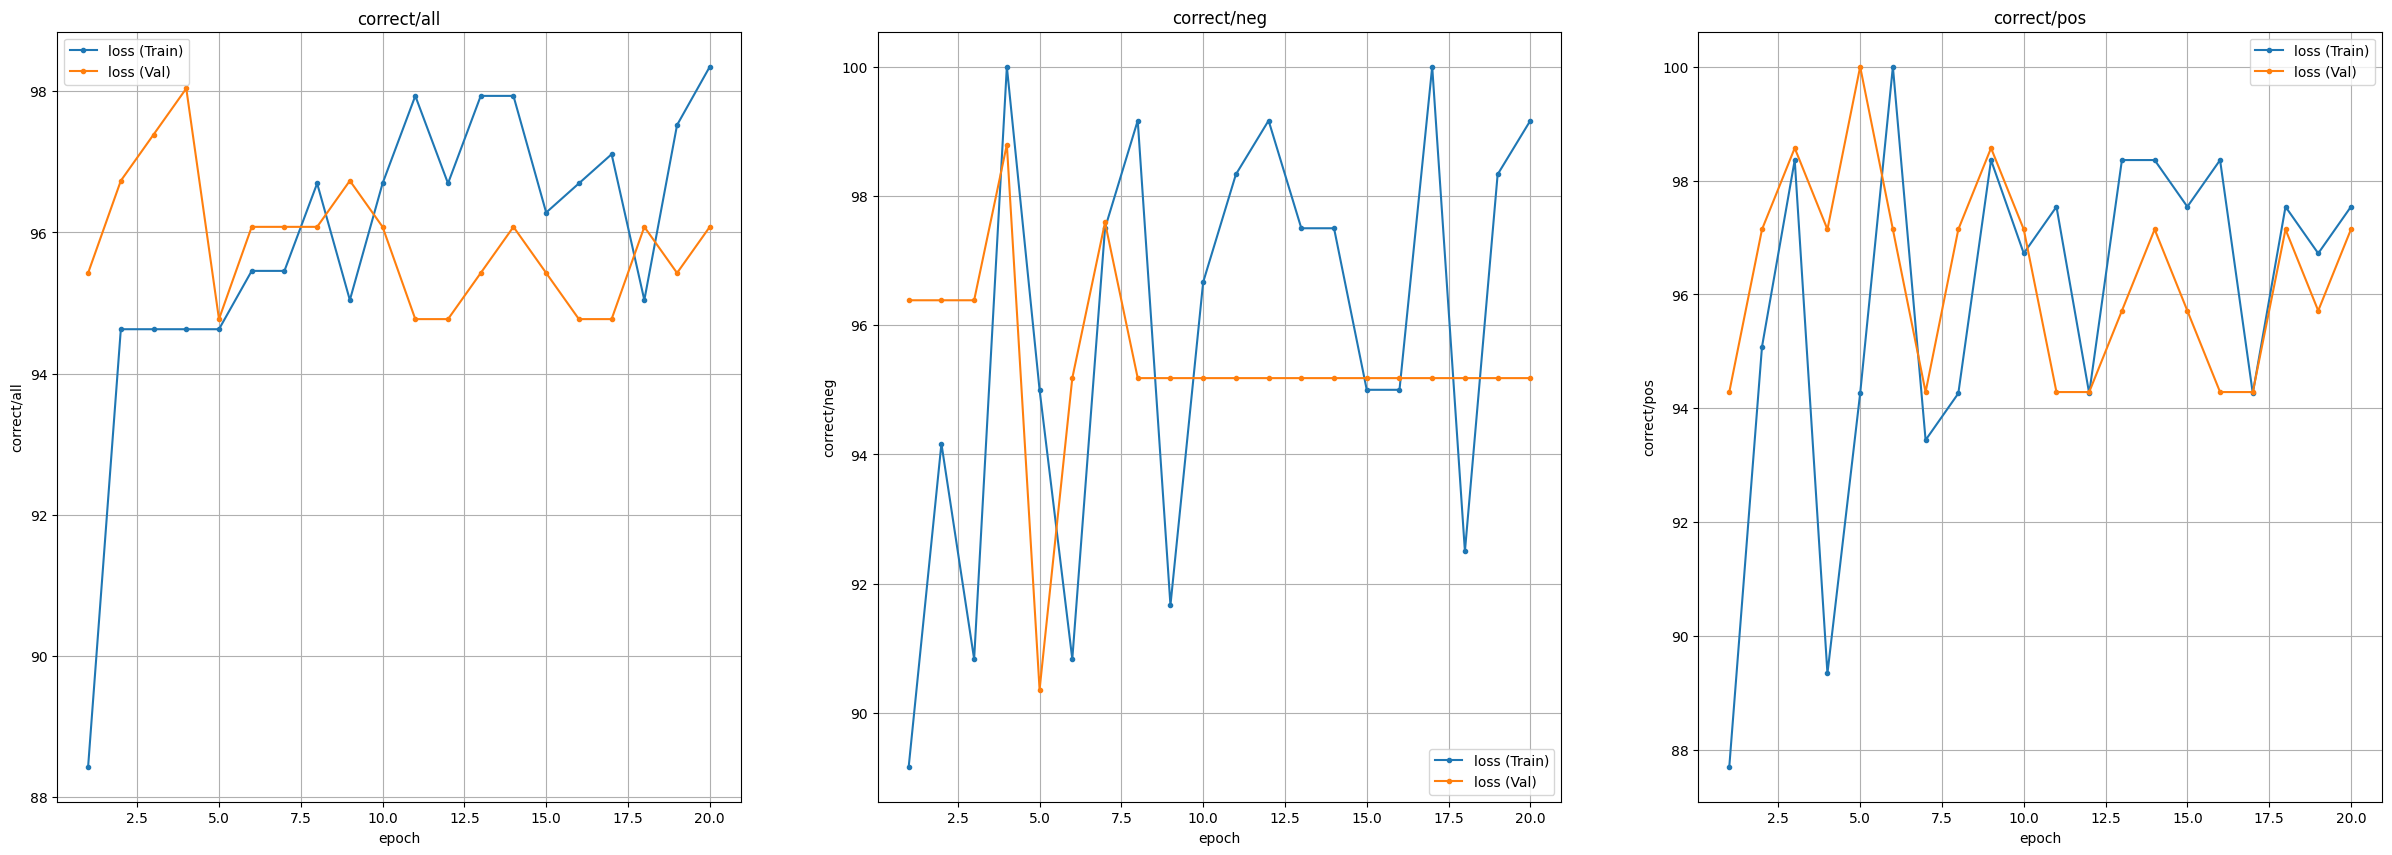

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline


fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(30,10))

# correct/all
ax1.plot(history_train['epoch_ndx'],history_train['correct/all'],
         marker='.',
         label='loss (Train)')
ax1.plot(history_val['epoch_ndx'],history_val['correct/all'],
         marker='.',
         label='loss (Val)')
ax1.legend(loc='best')
ax1.grid()
ax1.set_title('correct/all')
ax1.set_xlabel('epoch')
ax1.set_ylabel('correct/all')

# correct/all
ax2.plot(history_train['epoch_ndx'],history_train['correct/neg'],
         marker='.',
         label='loss (Train)')
ax2.plot(history_val['epoch_ndx'],history_val['correct/neg'],
         marker='.',
         label='loss (Val)')
ax2.legend(loc='best')
ax2.grid()
ax2.set_title('correct/neg')
ax2.set_xlabel('epoch')
ax2.set_ylabel('correct/neg')

# correct/all
ax3.plot(history_train['epoch_ndx'],history_train['correct/pos'],
         marker='.',
         label='loss (Train)')
ax3.plot(history_val['epoch_ndx'],history_val['correct/pos'],
         marker='.',
         label='loss (Val)')
ax3.legend(loc='best')
ax3.grid()
ax3.set_title('correct/pos')
ax3.set_xlabel('epoch')
ax3.set_ylabel('correct/pos')


plt.show()



#END